In [1]:
# Setup (PyTorch, paths, device, seeds)
# %load_ext autoreload
# %autoreload 2

from xray_models import (
    PneumoCNN, eval_one_epoch, fit,
    pick_threshold_youden, evaluate_with_threshold, SAM
)

from xray_helpers import (
    seed_all, compute_pos_weight,
    balance_val_train_split, plot_curves, get_dataloaders, download_xray_dataset
)

import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
seed_all(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 15
PATIENCE = int(EPOCHS * 2 / 3)
LR = 1e-4

In [4]:
base_dir, train_dir, val_dir, test_dir = download_xray_dataset()

Train dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Train dir contents: ['PNEUMONIA', 'NORMAL']
Val dir: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Val dir contents: ['PNEUMONIA', 'NORMAL']
Test dir: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Test dir contents: ['PNEUMONIA', 'NORMAL']


Before split:
train/NORMAL: 1341
train/PNEUMONIA: 3875
val/NORMAL: 8
val/PNEUMONIA: 8


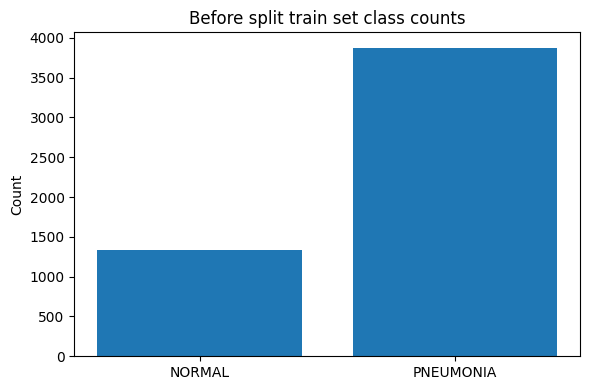

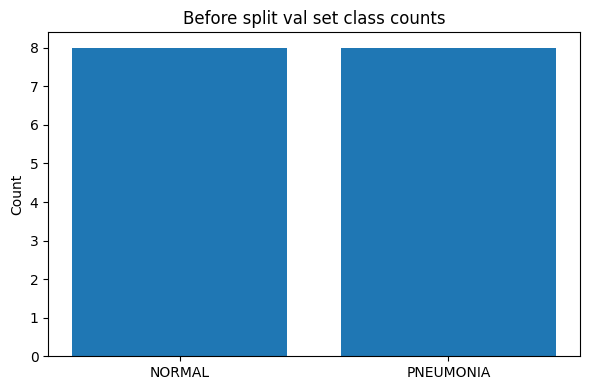

After split:
train/NORMAL: 1147
train/PNEUMONIA: 3300
val/NORMAL: 202
val/PNEUMONIA: 583


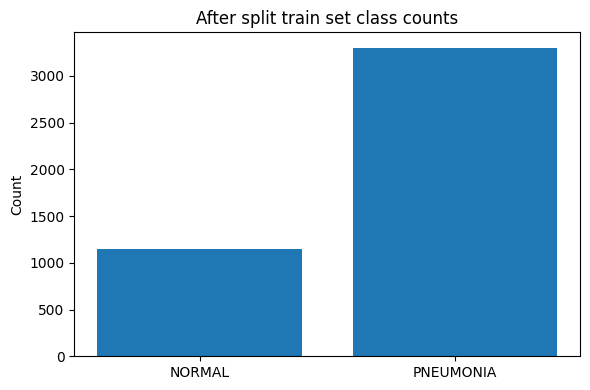

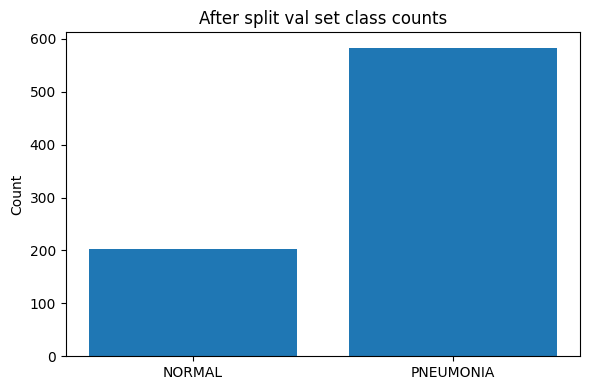

New dir: /tmp/chest_xray_split


In [5]:
new_base = balance_val_train_split(base_dir)
train_dir = os.path.join(new_base, 'train')
val_dir   = os.path.join(new_base, 'val')

In [6]:
model = PneumoCNN()
model = model.to(device)

data_sets, loaders = get_dataloaders(train_dir, val_dir, test_dir, BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

print(f"Classes => {data_sets['train_ds'].classes}, , Class indices => {data_sets['train_ds'].class_to_idx}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


Classes => ['NORMAL', 'PNEUMONIA'], , Class indices => {'NORMAL': 0, 'PNEUMONIA': 1}


Train counts -> NEG(NORMAL)=1147, POS(PNEUMONIA)=3300, pos_weight=0.348


[Train] Epoch 1/15:   0%|          | 0/139 [00:00<?, ?it/s]

Input batch shape: torch.Size([32, 3, 224, 224])


[Eval] Epoch 1/15: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Train Loss: 0.0829, Accuracy: 0.9013, AUC: 0.9697, PR 0.9890
Val Loss: 0.0291, Accuracy: 0.9809, AUC: 0.9989, PR 0.9996


[Eval] Epoch 2/15: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Train Loss: 0.0474, Accuracy: 0.9467, AUC: 0.9880, PR 0.9958
Val Loss: 0.0231, Accuracy: 0.9796, AUC: 0.9992, PR 0.9997


[Eval] Epoch 3/15: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Train Loss: 0.0381, Accuracy: 0.9564, AUC: 0.9926, PR 0.9974
Val Loss: 0.0239, Accuracy: 0.9860, AUC: 0.9989, PR 0.9996


[Eval] Epoch 4/15: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Train Loss: 0.0338, Accuracy: 0.9647, AUC: 0.9945, PR 0.9981
Val Loss: 0.0323, Accuracy: 0.9771, AUC: 0.9983, PR 0.9994


[Eval] Epoch 5/15: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Train Loss: 0.0323, Accuracy: 0.9633, AUC: 0.9947, PR 0.9981
Val Loss: 0.0285, Accuracy: 0.9822, AUC: 0.9987, PR 0.9996


[Eval] Epoch 6/15: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Train Loss: 0.0235, Accuracy: 0.9717, AUC: 0.9972, PR 0.9990
Val Loss: 0.0390, Accuracy: 0.9783, AUC: 0.9985, PR 0.9995


[Eval] Epoch 7/15: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Train Loss: 0.0212, Accuracy: 0.9723, AUC: 0.9969, PR 0.9990
Val Loss: 0.0233, Accuracy: 0.9822, AUC: 0.9993, PR 0.9997


[Eval] Epoch 8/15: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Train Loss: 0.0198, Accuracy: 0.9750, AUC: 0.9978, PR 0.9992
Val Loss: 0.0273, Accuracy: 0.9873, AUC: 0.9991, PR 0.9997


[Eval] Epoch 9/15: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Train Loss: 0.0184, Accuracy: 0.9737, AUC: 0.9977, PR 0.9992
Val Loss: 0.0232, Accuracy: 0.9885, AUC: 0.9994, PR 0.9998


[Eval] Epoch 10/15: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Train Loss: 0.0171, Accuracy: 0.9784, AUC: 0.9979, PR 0.9993
Val Loss: 0.0425, Accuracy: 0.9822, AUC: 0.9987, PR 0.9996


[Eval] Epoch 11/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0150, Accuracy: 0.9802, AUC: 0.9985, PR 0.9995
Val Loss: 0.0375, Accuracy: 0.9860, AUC: 0.9990, PR 0.9997


[Eval] Epoch 12/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0166, Accuracy: 0.9784, AUC: 0.9980, PR 0.9993
Val Loss: 0.0218, Accuracy: 0.9834, AUC: 0.9992, PR 0.9997


[Eval] Epoch 13/15: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


Train Loss: 0.0142, Accuracy: 0.9825, AUC: 0.9988, PR 0.9996
Val Loss: 0.0374, Accuracy: 0.9898, AUC: 0.9993, PR 0.9998


[Eval] Epoch 14/15: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Train Loss: 0.0107, Accuracy: 0.9836, AUC: 0.9991, PR 0.9997
Val Loss: 0.0274, Accuracy: 0.9885, AUC: 0.9993, PR 0.9998


[Eval] Epoch 15/15: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Train Loss: 0.0112, Accuracy: 0.9843, AUC: 0.9990, PR 0.9997
Val Loss: 0.0461, Accuracy: 0.9847, AUC: 0.9991, PR 0.9997
Training finished in 16.4 min. Best val AUC: 0.9994


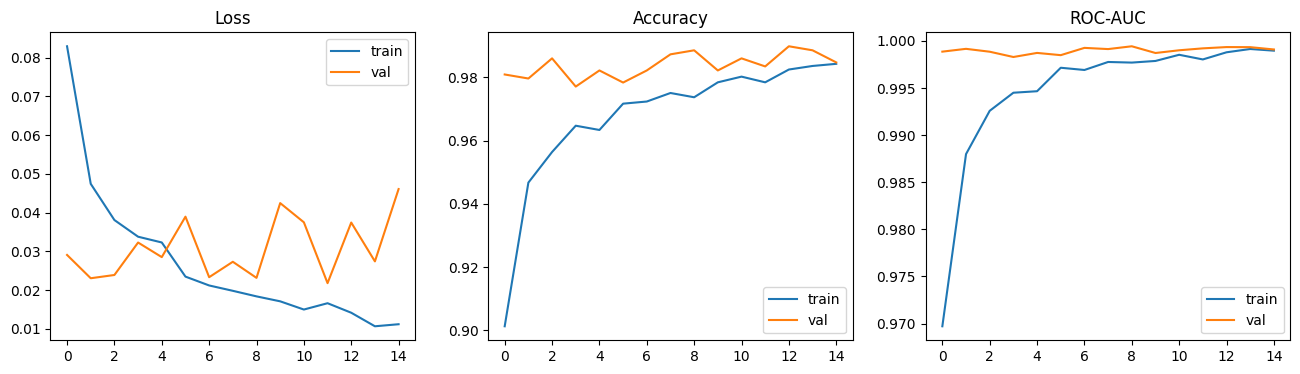

In [7]:
pos_weight = compute_pos_weight(data_sets['train_ds'])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
# criterion = nn.BCEWithLogitsLoss()
# optimizer = AdamW(model.parameters(), lr=LR)
optimizer = SAM(model.parameters(), base_optimizer=torch.optim.AdamW, lr=LR, weight_decay=1e-4, rho=0.05)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

history, best_val_auc = fit(model, loaders['train_loader'], loaders['val_loader'],
                            criterion, optimizer, device, scheduler, epochs=EPOCHS, patience=PATIENCE)

plot_curves(history)

In [8]:
_, _, _, va_auc, va_probs, va_targets = eval_one_epoch(model, loaders['val_loader'], 1, criterion, device, 1)
best_thr = pick_threshold_youden(va_targets, va_probs)
print("Chosen threshold:", best_thr)

[Eval] Epoch 1/1: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]

Chosen threshold: 0.955894947052002


[Eval] Epoch 1/15: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]

probs[:10] = [0.02873328 0.05031942 0.26351017 0.76982725 0.22361302 0.09535723
 0.4623385  0.6842395  0.7398789  0.19801515]
targets[:10] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TEST — loss: 0.5642 | acc@thr: 0.9247 | auc: 0.9815
Specificity: 0.8205 | Sensitivity: 0.9872 | Balanced Acc: 0.9038
PR-AUC from average_precision_score: 0.9866  | PR-AUC from sklearn.metrics: 0.9866
Confusion Matrix :
 [[192  42]
 [  5 385]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.9746    0.8205    0.8910       234
   PNEUMONIA     0.9016    0.9872    0.9425       390

    accuracy                         0.9247       624
   macro avg     0.9381    0.9038    0.9167       624
weighted avg     0.9290    0.9247    0.9232       624



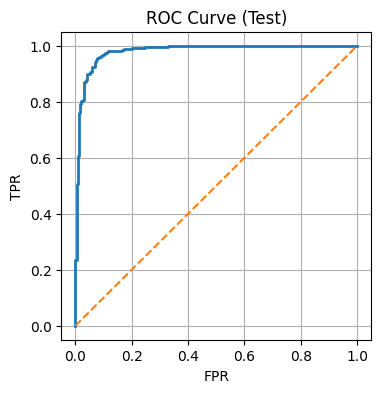

In [9]:
evaluate_with_threshold(model, loaders['test_loader'], criterion, best_thr, device, EPOCHS)